In [1]:
# NOTE: Setting the KMP_DUPLICATE_LIB_OK env var might be needed to avoid crashes:

# export KMP_DUPLICATE_LIB_OK=TRUE

In [2]:
from src.app import predict_seq
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from abnumber import Chain
from matplotlib import pyplot as plt
from matplotlib import patches

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
SCHEME = 'aho'
CDR_DEFINITION = 'north'

In [4]:
example_pred, example_attn = predict_seq(
    seq='QVQLQQSGAELARPGASVKMSCKASGYTFTRYTMHWVKQRPGQGLEWIGYINPSRGYTNYNQKFKDKATLTTDK'
        'SSSTAYMQLSSLTSEDSAVYYCARYYDDHYCLDYWGQGTTLTVSS',
    chain_type='H',
    model_version='latest',
    return_attention=True
)

In [5]:
example_pred, example_attn = predict_seq(
    seq='QVQLQQSGAELARPGASVKMSCKASGYTFTRYTMHWVKQRPGQGLEWIGYINPSRGYTNYNQKFKDKATLTTDK'
        'SSSTAYMQLSSLTSEDSAVYYCARYYDDHYCLDYWGXXXXXXXXX',
    chain_type='H',
    model_version='latest',
    return_attention=True
)

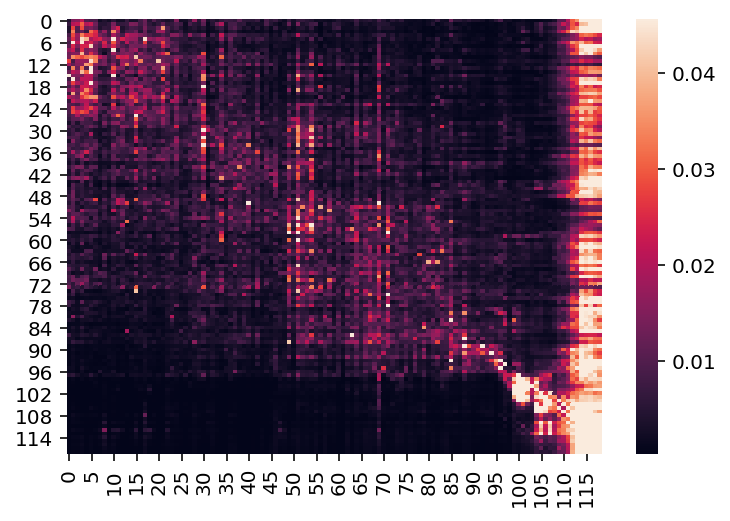

In [6]:
sns.heatmap(example_attn.mean(axis=0), robust=True);

In [7]:
mabs = pd.read_csv('../../data/tasks/humanness/imgt_mab_db.tsv', sep='\t', index_col=0)
mabs.head()

,Antibody,Species
INN_Number,,
8659,abagovomab,Mouse
10881,abelacimab,Human
9509,abituzumab,Humanized
10745,abrezekimab,Humanized
9921,abrilumab,Human


In [8]:
POSITIONS = [
    '1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
    '21', '22', '23', '24', '25', '26', '27', '29', '30', '31', '32', '33', '39', '40', '41', '42', '43', '44', 
    '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '65', 
    '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', 
    '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', 
    '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '133', '134', '135', 
    '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149'
]
len(POSITIONS)

120

In [13]:
prev = -1
for position in POSITIONS:
    position = int(position)
    if position != prev + 1:
        print(prev, position)
    prev = position

-1 1
7 9
27 29
33 39
61 65
113 133


In [14]:
chains = [Chain(r.seq, SCHEME, CDR_DEFINITION, name=r.id) 
          for r in SeqIO.parse('../../data/tasks/humanness/imgt_mab_db.fa', 'fasta')
          if len(r.seq) == len(POSITIONS)
         ]
len(chains)

78

In [15]:
heavy_chains = [c for c in chains if c.is_heavy_chain() and [p.format(chain_type=False) for p in c.positions] == POSITIONS]
len(heavy_chains)

64

In [16]:
raw_attentions = np.zeros(shape=(len(heavy_chains), 4, 8, len(POSITIONS), len(POSITIONS)))
for i, chain in enumerate(heavy_chains):
    pred, attn_layers = predict_seq(
        seq=chain.seq,
        chain_type=chain.chain_type,
        model_version='latest',
        return_attention=True,
        return_all_hiddens=True
    ) 
    
    raw_attentions[i] = attn_layers
    
raw_attentions.shape

(64, 4, 8, 120, 120)

In [17]:
mean_attentions = raw_attentions.mean(axis=0)
mean_attentions.shape

(4, 8, 120, 120)

In [18]:
chains[0].print(numbering=True)

0       1         2        3    4         5         6     7         8         9         10        11   13     14        
123456790123456789012345679012390123456789012345678905678901234567890123456789012345678901234567890123434567890123456789
QVTLKESGPVLVKPTETLTLTCTVSGFSLTNYHVQWIRQPPGKALEWLGVMWSDGDTSFNSVLKSRLTISRDTSKSQVVLTMTNMDPVDTATYYCARDGTIAAMDYFDYWGQGTLVTVSS
                      ^^^^^^^^^^^^^              ^^^^^^^^^                                     ^^^^^^^^^^^^^^           


In [19]:
REGIONS = {'CDR1': (22, 35), 'CDR2': (49, 59), 'DE': (72, 79), 'CDR3': (96, 109)}

print('Region boundaries (raw position):')
REGIONS

Region boundaries (raw position):


{'CDR1': (22, 35), 'CDR2': (49, 59), 'DE': (72, 79), 'CDR3': (96, 109)}

In [20]:
def plot_attention_heatmap(attn, ax, cbar=True, text=True, linewidth=8):
    df = pd.DataFrame(attn)
    df.index = POSITIONS
    df.columns = POSITIONS
    df.index.name = 'Attention from position (AHo)'
    df.columns.name = 'Attention to position (AHo)'
    colors = ['#00ee99','#eeee00','#ff9900','#ff3300']
    text_colors = ['#00dd77','#ccbb00','#ee8800','#ee3300']
    cmap = sns.cubehelix_palette(start=.5, hue=1.2, rot=-0.45, dark=0.05, light=0.95, reverse=True, as_cmap=True)
    sns.heatmap(df, robust=True, ax=ax, cbar=cbar, cbar_kws=dict(label='Attention'), cmap=cmap, vmax=0.05)
    for i, (region, (start, end)) in enumerate(REGIONS.items()):
        if text:
            ax.text((start+end)/2, 0, region, color=text_colors[i], fontsize=11, va='bottom', ha='center')
        ax.plot([start, end], [0, 0], linewidth=linewidth, ls='-', color=colors[i])
        ax.plot([0, 0], [start, end], linewidth=linewidth, ls='-', color=colors[i])
    return ax

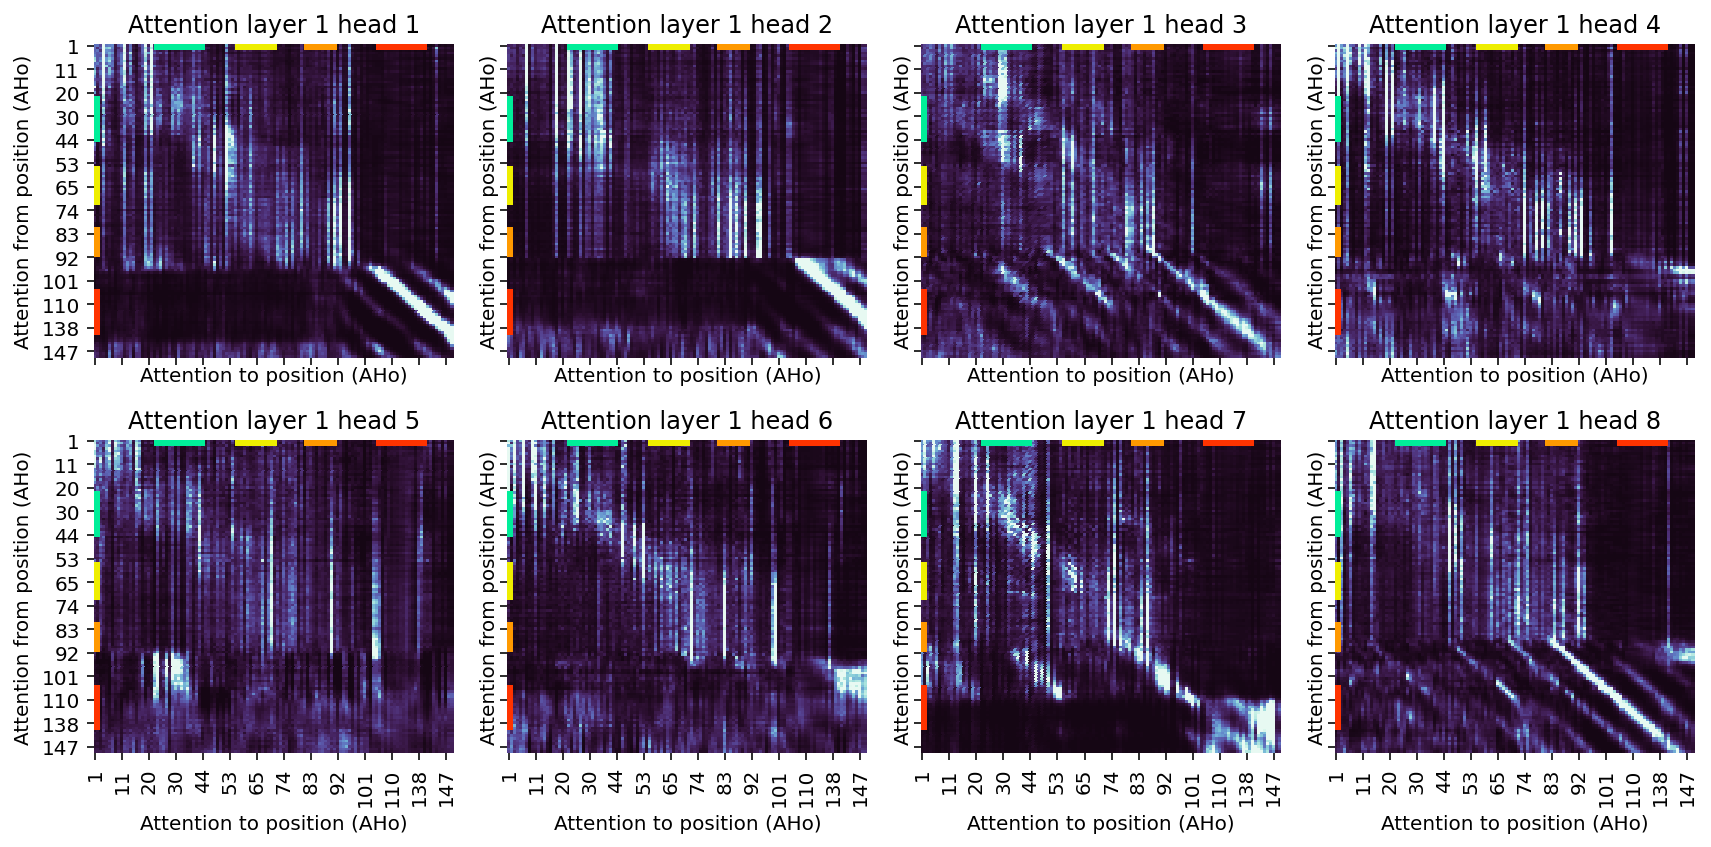

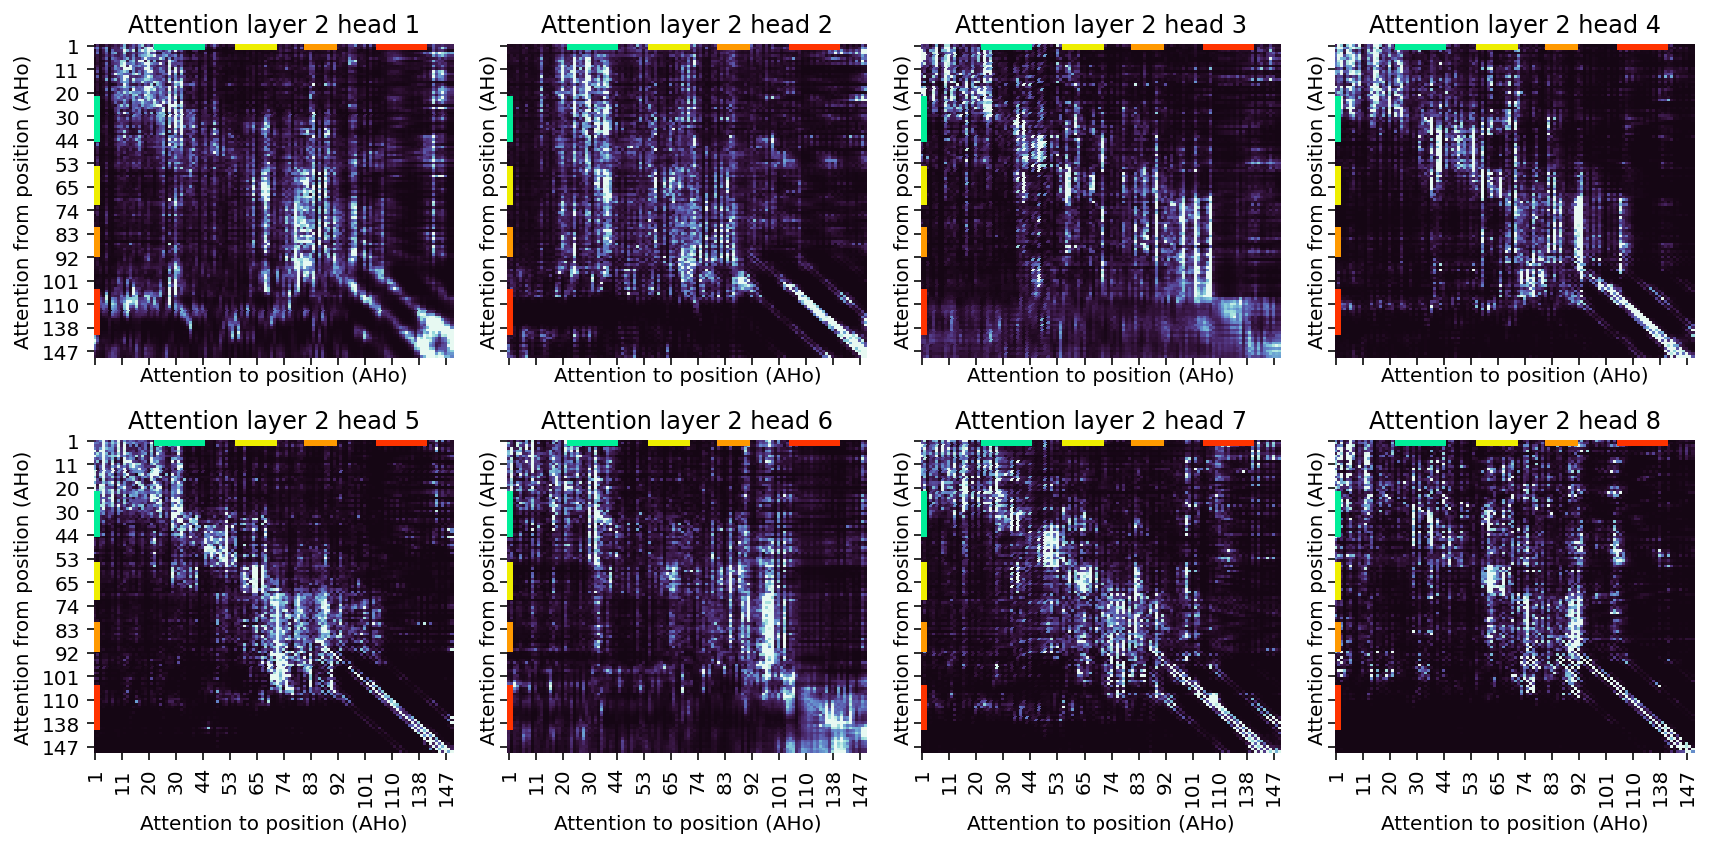

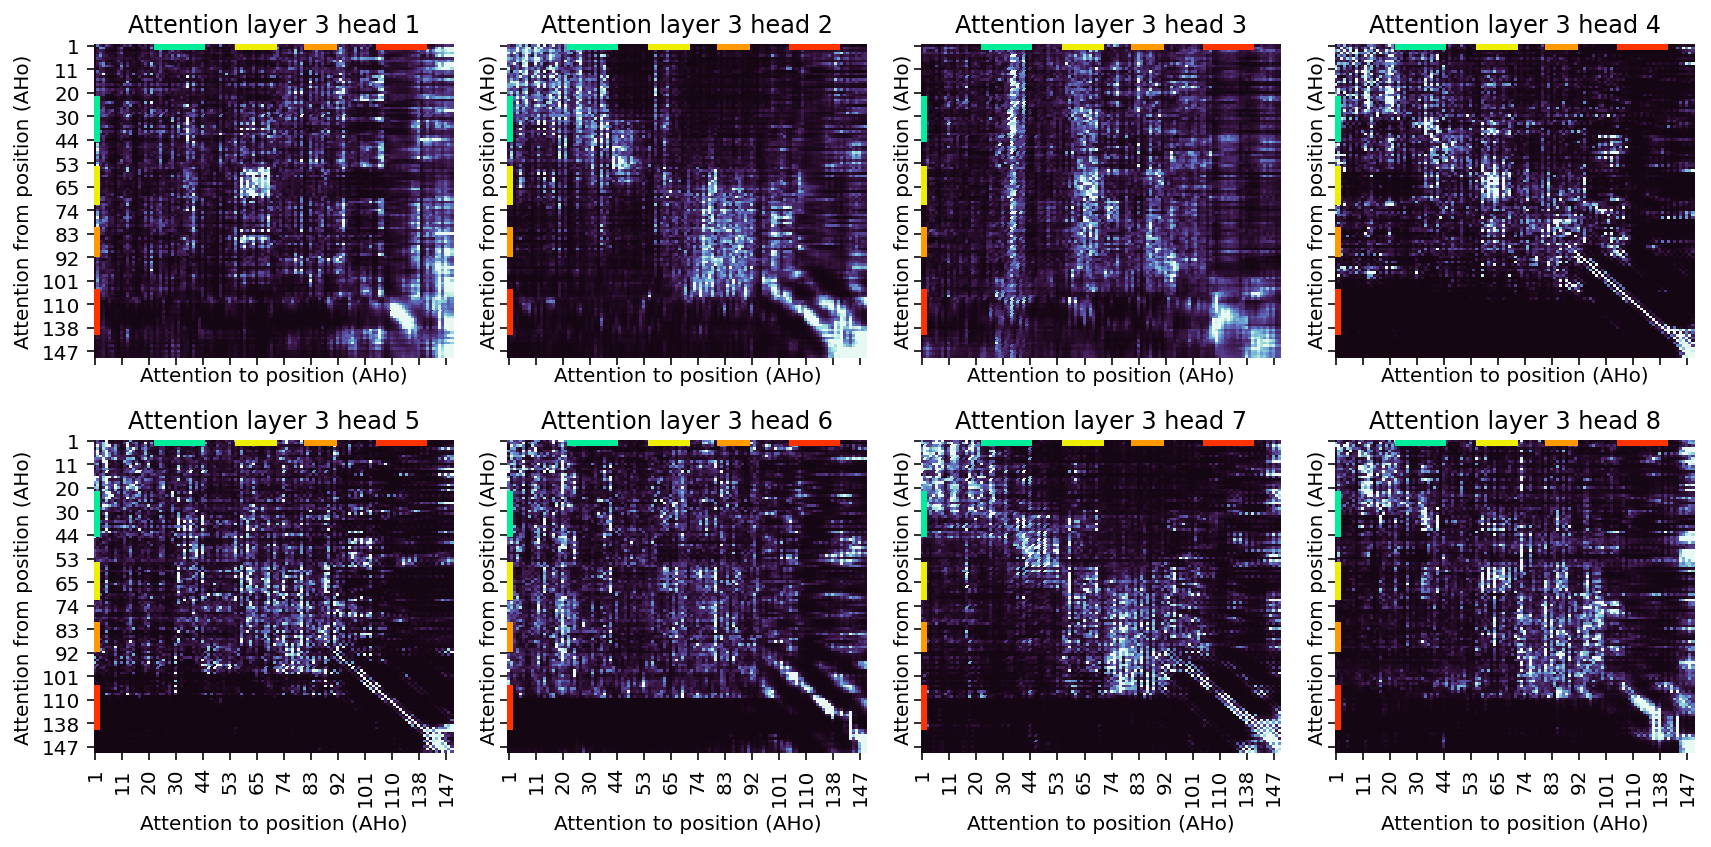

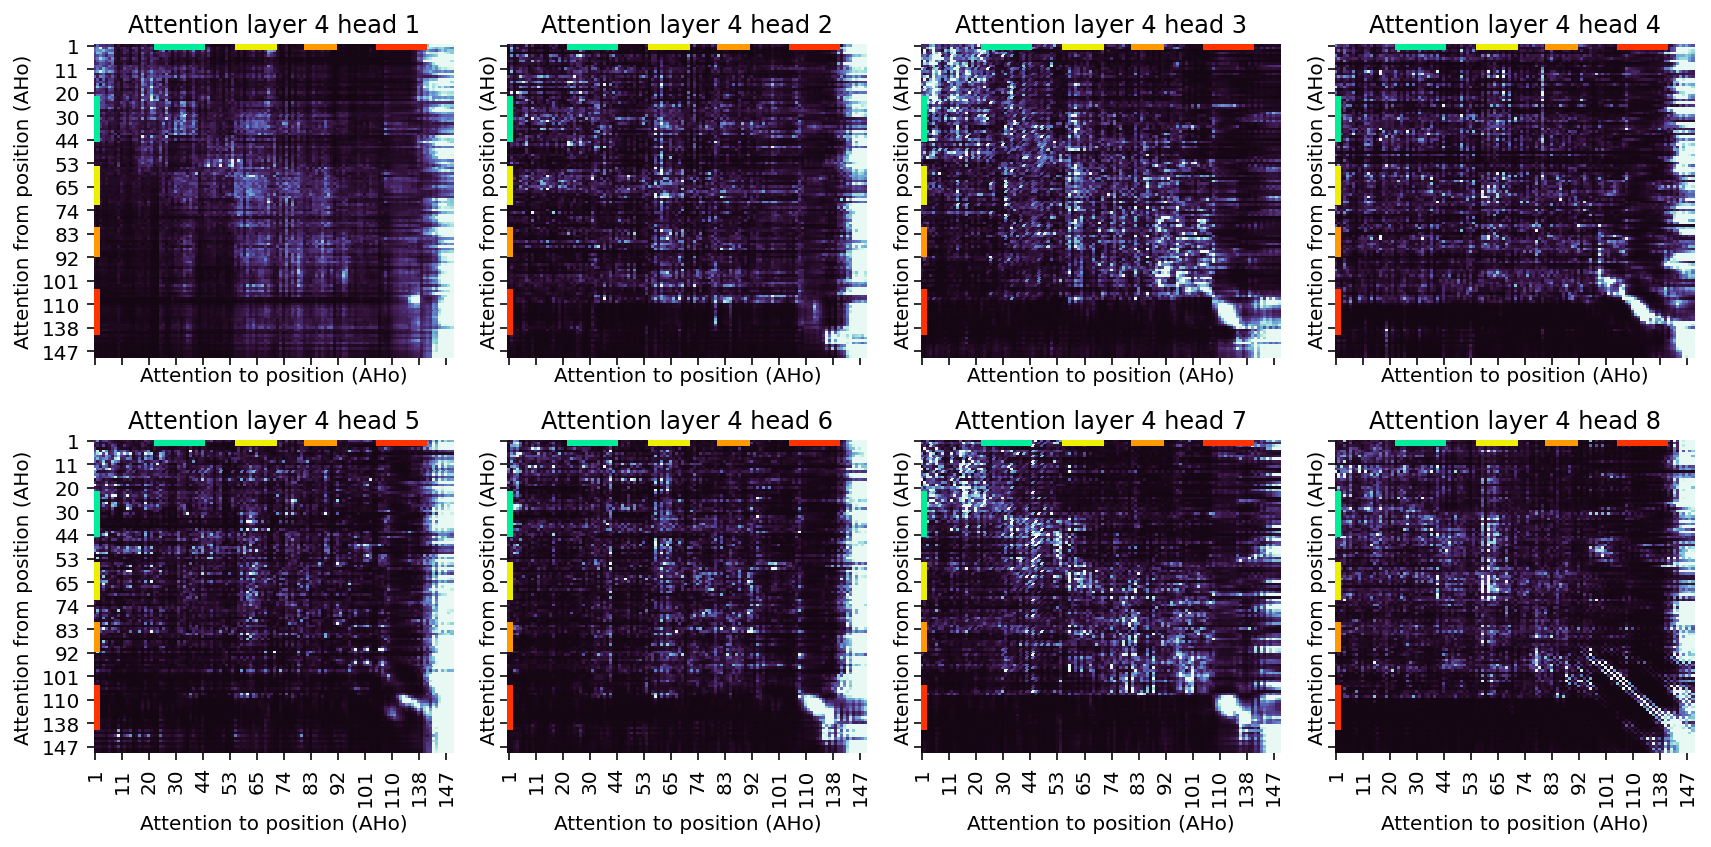

In [21]:
for layer, attn_layer in enumerate(mean_attentions):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
    for i, attn in enumerate(attn_layer):
        ax = plot_attention_heatmap(attn, axes.flatten()[i], cbar=False, text=False, linewidth=6)
        ax.set_title(f'Attention layer {layer+1} head {i+1}')

    fig.tight_layout();
    plt.show()

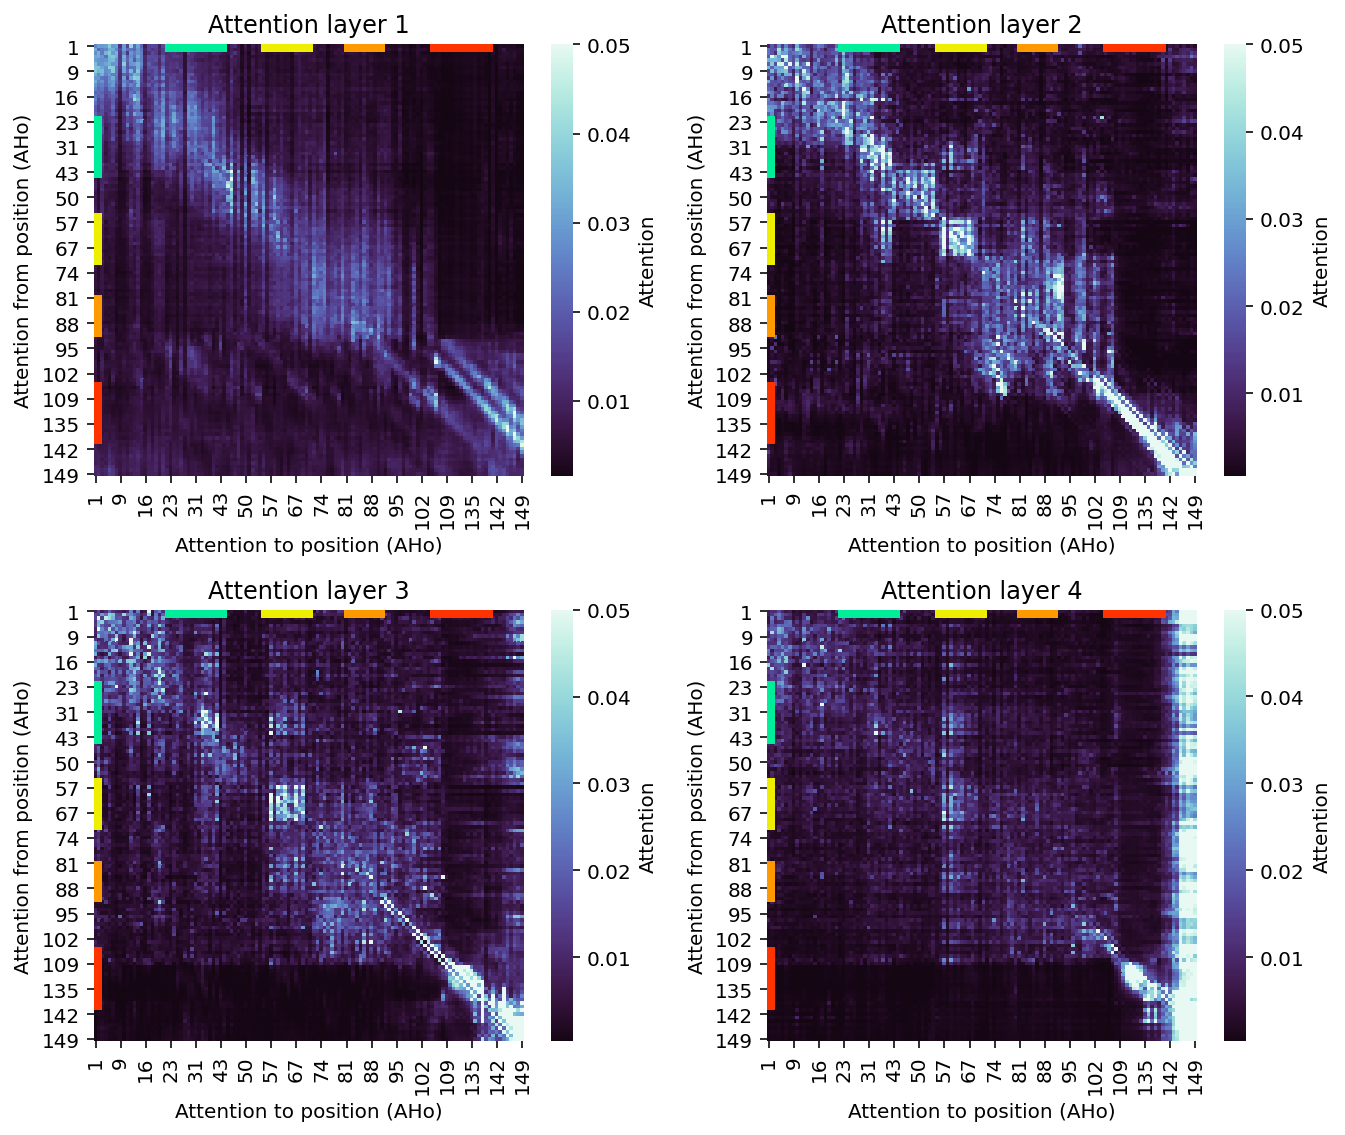

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(9.5, 8))
for layer, attn_layer in enumerate(mean_attentions):
    ax = plot_attention_heatmap(attn_layer.mean(axis=0), ax=axes.flatten()[layer], text=False)
    ax.set_title(f'Attention layer {layer+1}')

fig.tight_layout();
plt.show()

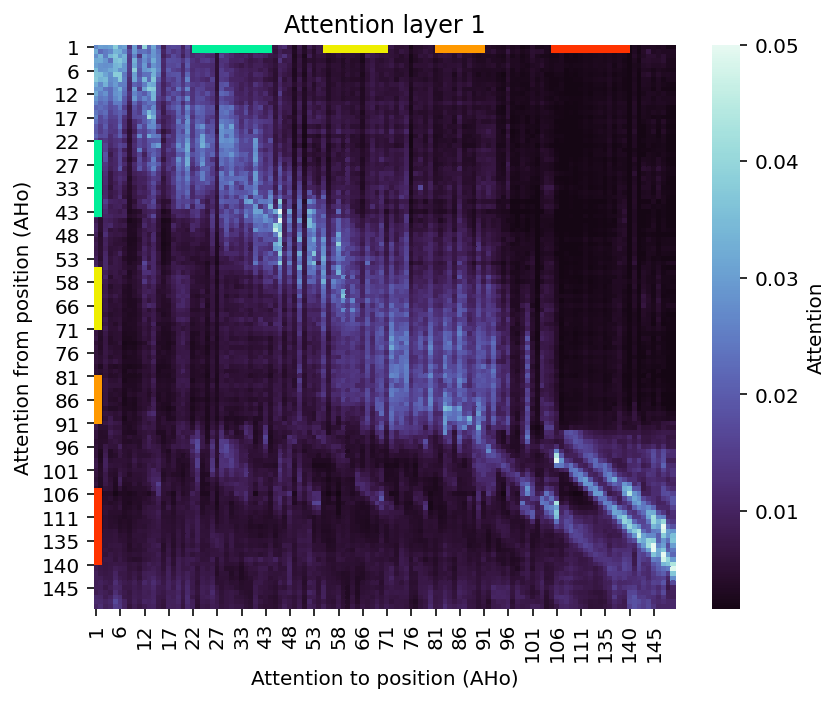

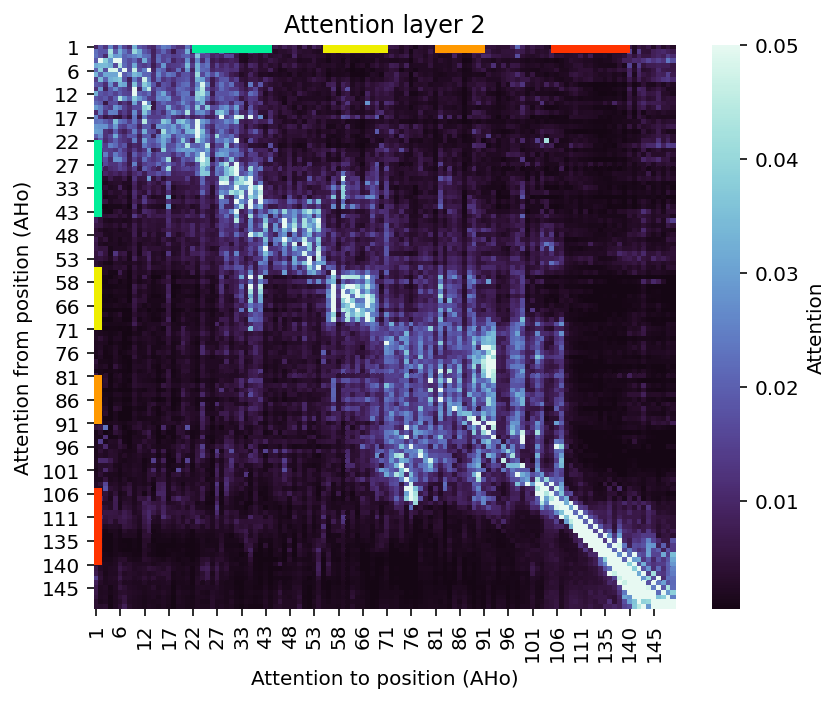

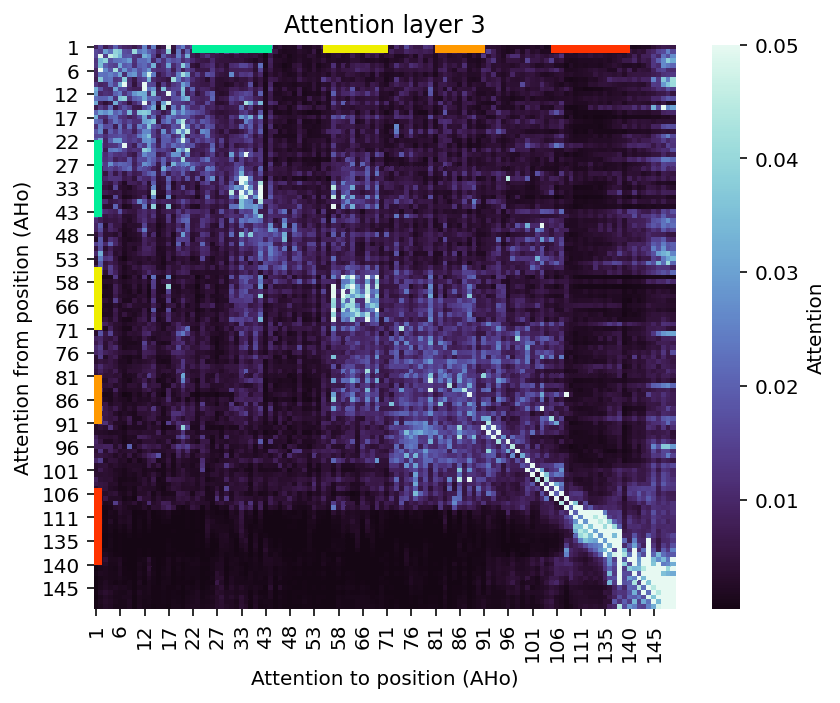

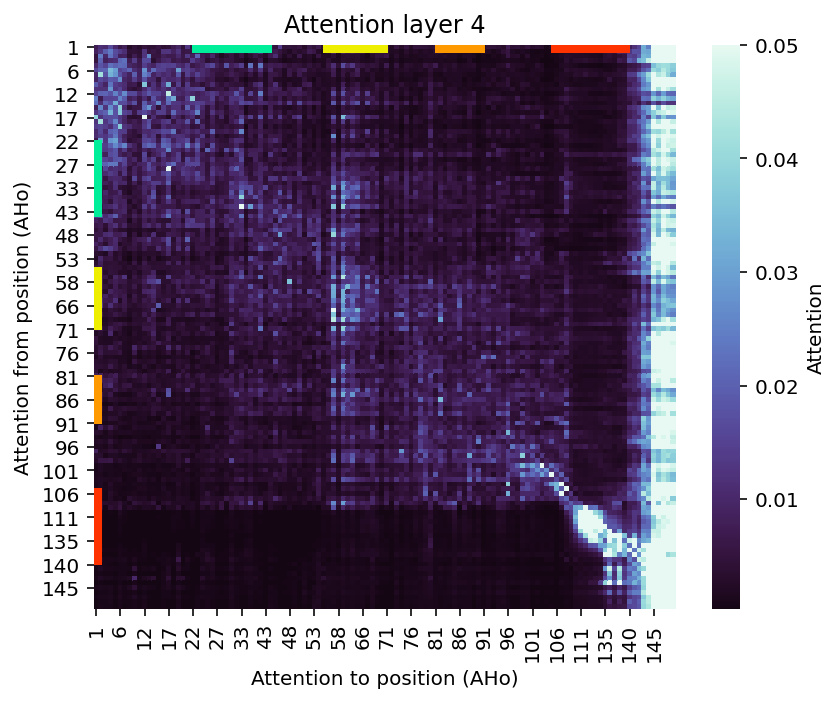

In [23]:
for layer, attn_layer in enumerate(mean_attentions):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax = plot_attention_heatmap(attn_layer.mean(axis=0), ax=ax, text=False)
    ax.set_title(f'Attention layer {layer+1}')

    fig.tight_layout();
    plt.show()

In [28]:
for layer, attn_layer in enumerate(mean_attentions):
    df = pd.DataFrame(attn_layer.mean(axis=0), index=POSITIONS, columns=POSITIONS)
    df.index.name = 'AHo'
    df.insert(0, 'region', [p.get_region() for p in heavy_chains[0].positions])
    df.to_csv(f'../../data/tasks/attention/attn_layer_{layer+1}_mean.tsv', sep='\t')

In [31]:
attn_layer2 = pd.read_csv(f'../../data/tasks/attention/attn_layer_2_mean.tsv', sep='\t', index_col=0)
attn_layer2.index = attn_layer2.index.astype(str)
attn_layer2.head()

,region,1,2,3,4,5,6,7,9,10,...,140,141,142,143,144,145,146,147,148,149
AHo,,,,,,,,,,,,,,,,,,,,,
1,FR1,0.009427,0.018574,0.012807,0.026029,0.013646,0.025591,0.015260,0.010951,0.032878,...,0.006158,0.002163,0.005656,0.004424,0.006697,0.002805,0.006735,0.003190,0.005280,0.002747
2,FR1,0.022501,0.018483,0.018116,0.042158,0.019624,0.032527,0.022993,0.016679,0.039758,...,0.014907,0.002278,0.013588,0.004680,0.004472,0.008073,0.009529,0.010413,0.008460,0.006954
3,FR1,0.023211,0.018530,0.011126,0.038377,0.028963,0.030148,0.020489,0.023035,0.025807,...,0.008124,0.005086,0.008916,0.005563,0.005920,0.008106,0.009893,0.008407,0.013779,0.010702
4,FR1,0.019138,0.064663,0.037791,0.028782,0.053247,0.061055,0.020687,0.016787,0.021118,...,0.008377,0.010883,0.010095,0.012362,0.015752,0.012633,0.014852,0.012214,0.023780,0.017046
5,FR1,0.032333,0.033977,0.034647,0.031858,0.016710,0.043816,0.021654,0.016810,0.031346,...,0.015242,0.002644,0.013689,0.005197,0.007386,0.007535,0.008618,0.007969,0.008363,0.005845


In [105]:
region2region = []
for region1 in attn_layer2['region'].unique():
    for region2 in attn_layer2['region'].unique():
        rows = attn_layer2.index[attn_layer2['region'] == region1]
        columns = attn_layer2.index[attn_layer2['region'] == region2]
        region2region.append({
            'from': region1,
            'to': region2,
            'attention': attn_layer2.loc[rows, columns].mean(axis=1).mean()
        })
region2region = pd.DataFrame(region2region)
region2region.head()

,from,to,attention
0,FR1,FR1,0.021671
1,FR1,CDR1,0.015133
2,FR1,FR2,0.003825
3,FR1,CDR2,0.003998
4,FR1,FR3,0.003566


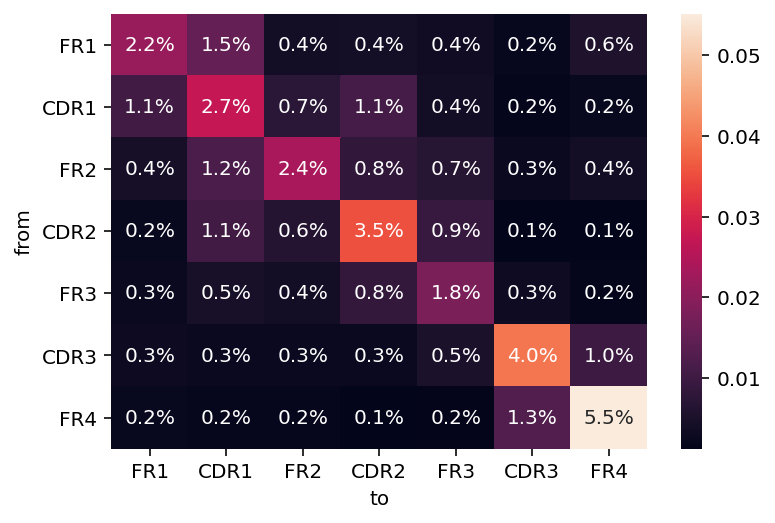

In [144]:
ax = sns.heatmap(
    data=region2region.set_index(['from','to'])['attention'].unstack().loc[attn_layer2['region'].unique(), attn_layer2['region'].unique()],
    annot=True,
    fmt='.1%'
);
ax.set_yticklabels(attn_layer2['region'].unique(), rotation=0);

In [145]:
# same_vs_other = []
# for region in attn_layer2['region'].unique().tolist() + ['DE']:
#     if region == 'DE':
#         mask = np.array([REGIONS['DE'][0] <= i < REGIONS['DE'][1] for i in range(len(attn_layer2))])
#     else:
#         mask = attn_layer2['region'] == region  
#     same = attn_layer2.drop(['region'], axis=1).loc[mask, mask].mean(axis=1).mean()
#     other = attn_layer2.drop(['region'], axis=1).loc[mask, ~mask].mean(axis=1).mean()
#     same_vs_other.append({
#         'region': region,
#         'to self': same,
#         'to others': other,
#         'increase': same / other
#     })
# same_vs_other = pd.DataFrame(same_vs_other).set_index('region')
# same_vs_other

In [146]:
same_vs_other = region2region.groupby('from').apply(lambda rows: rows.groupby(rows['to'] == rows.name)['attention'].mean())
same_vs_other.columns = ['Other regions', 'Same region']
same_vs_other['increase'] = same_vs_other['Same region'] / same_vs_other['Other regions']
same_vs_other

,Other regions,Same region,increase
from,,,
CDR1,0.006156,0.027195,4.417622
CDR2,0.005143,0.035423,6.887699
CDR3,0.004388,0.039678,9.043476
FR1,0.005706,0.021671,3.798137
FR2,0.006297,0.023567,3.742784
FR3,0.004111,0.018256,4.440993
FR4,0.003665,0.055159,15.049638


In [147]:
same_vs_other['increase'].apply('{:.1f}'.format)

from
CDR1     4.4
CDR2     6.9
CDR3     9.0
FR1      3.8
FR2      3.7
FR3      4.4
FR4     15.0
Name: increase, dtype: object

In [151]:
cdr2_vs_other = []
de_mask = np.array([REGIONS['DE'][0] <= i < REGIONS['DE'][1] for i in range(len(attn_layer2))])
for region in attn_layer2['region'].unique().tolist() + ['DE']:
    if region == 'DE':
        mask = de_mask
    elif region == 'FR3':
        mask = (attn_layer2['region'] == region) & ~de_mask
        region = 'FR3_without_DE'
    else:
        mask = attn_layer2['region'] == region 
    cdr2_mask = attn_layer2['region'] == 'CDR2' 
    cdr2_vs_other.append({
        'region': region,
        'attention': attn_layer2.drop(['region'], axis=1).loc[cdr2_mask, mask].mean(axis=1).mean()
    })
cdr2_vs_other = pd.DataFrame(cdr2_vs_other).set_index('region')['attention']
cdr2_vs_other

region
FR1               0.002300
CDR1              0.010635
FR2               0.006365
CDR2              0.035423
FR3_without_DE    0.007838
CDR3              0.001224
FR4               0.001256
DE                0.014386
Name: attention, dtype: float64

In [166]:
for region in ['CDR1', 'CDR2', 'DE', 'CDR3']:
    same = cdr2_vs_other[region]
    frameworks = cdr2_vs_other[['FR1', 'FR2', 'FR3_without_DE', 'FR4']].mean()
    increase = same / frameworks
    print(region, '{:.1f}'.format(increase))

CDR1 2.4
CDR2 8.0
DE 3.2
CDR3 0.3


In [160]:
RESIDUES = list('ACDEFGHIKLMNPQRSTVWY')

In [123]:
attentions_per_residue = np.zeros(shape=(len(heavy_chains), 4, 8, 20))
for i, chain in enumerate(heavy_chains):
    pred, attn_layers = predict_seq(
        seq=chain.seq,
        chain_type=chain.chain_type,
        model_version='latest',
        return_attention=True,
        return_all_hiddens=True
    )
    seq_array = np.array(list(chain.seq))
    
    for layer, raw_attention_per_head in enumerate(attn_layers):
        for head, head_raw_attention in enumerate(raw_attention_per_head):
            attn_at_position = head_raw_attention.sum(axis=0)
            attn_per_residue = pd.Series(attn_at_position).groupby(seq_array).sum().reindex(RESIDUES, fill_value=0)
            attn_per_residue = attn_per_residue / attn_per_residue.sum()
            attentions_per_residue[i][layer][head] = attn_per_residue.values
    
attentions_per_residue.shape

(64, 4, 8, 20)

In [73]:
mean_attentions_per_residue = attentions_per_residue.mean(axis=0)
mean_attentions_per_residue.shape

(4, 8, 20)

In [74]:
TAYLOR_DICT = {
  'A': '#ccff00',
  'V': '#99ff00',
  'I': '#66ff00',
  'L': '#33ff00',
  'M': '#00ff00',
  'F': '#00ff66',
  'Y': '#00ffcc',
  'W': '#00ccff',
  'H': '#3366ff',
  'R': '#707dff',
  'K': '#a385ff',
  'N': '#cc00ff',
  'Q': '#ff00cc',
  'E': '#ff0066',
  'D': '#ff0000',
  'S': '#ff3300',
  'T': '#ff6600',
  'G': '#ff9900',
  'P': '#ffcc00',
  'C': '#ffff00'
}
TAYLOR = [TAYLOR_DICT[aa] for aa in RESIDUES]

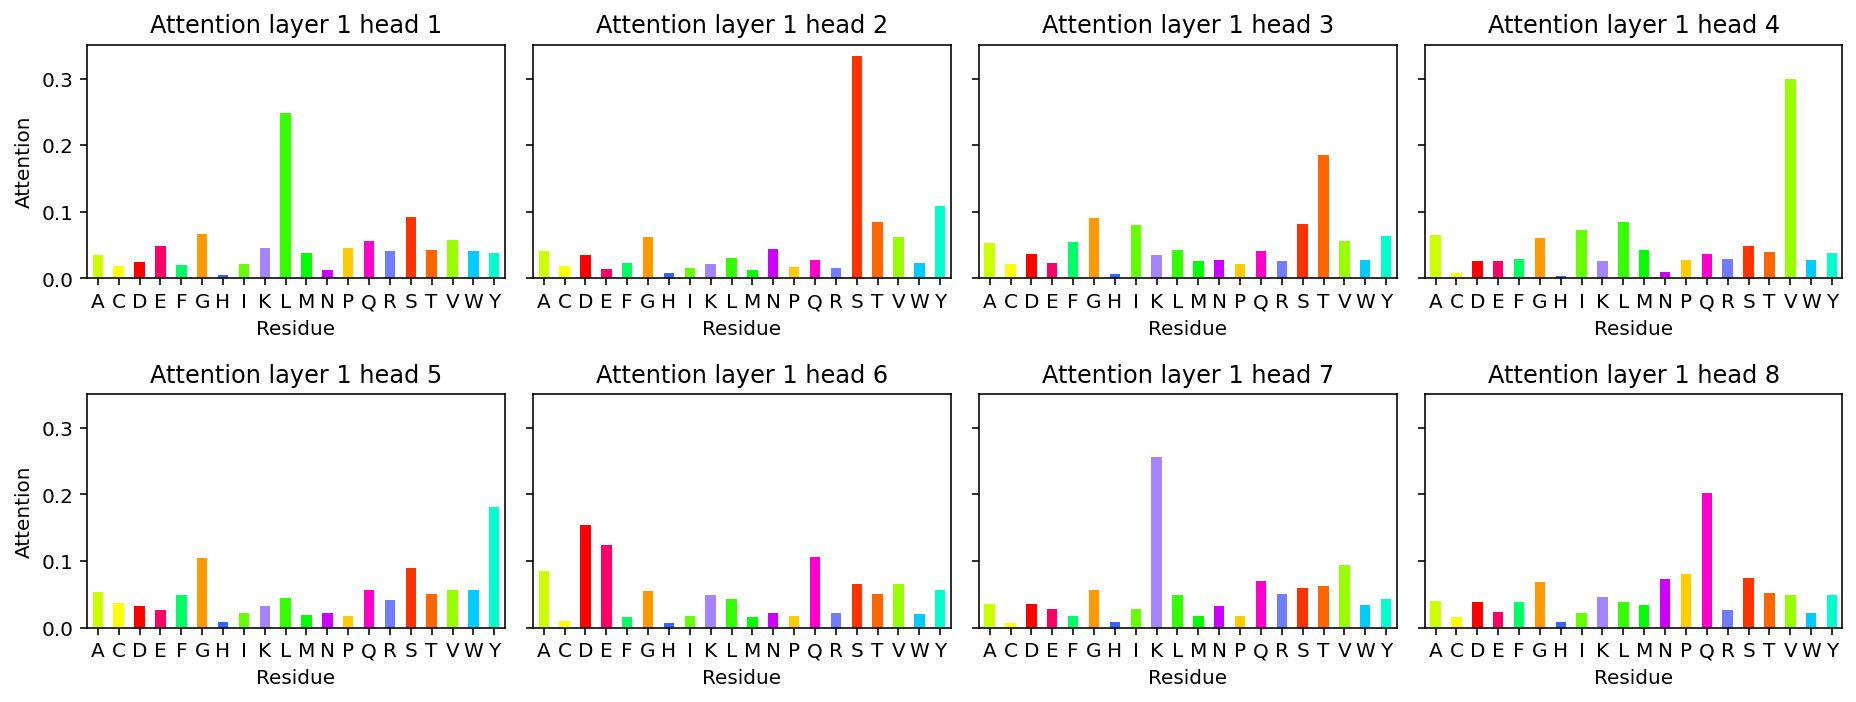

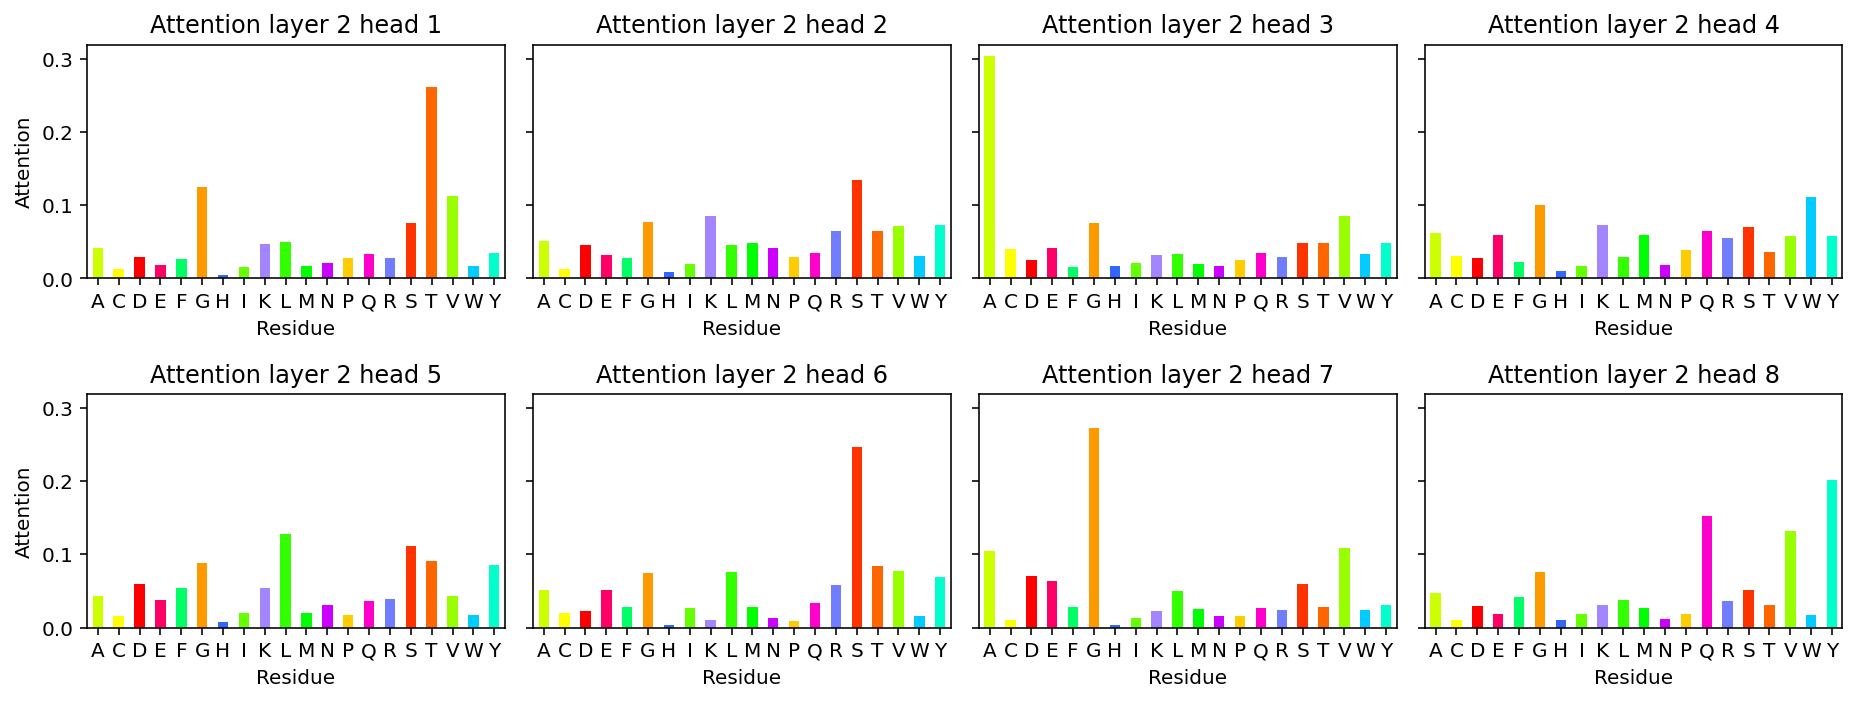

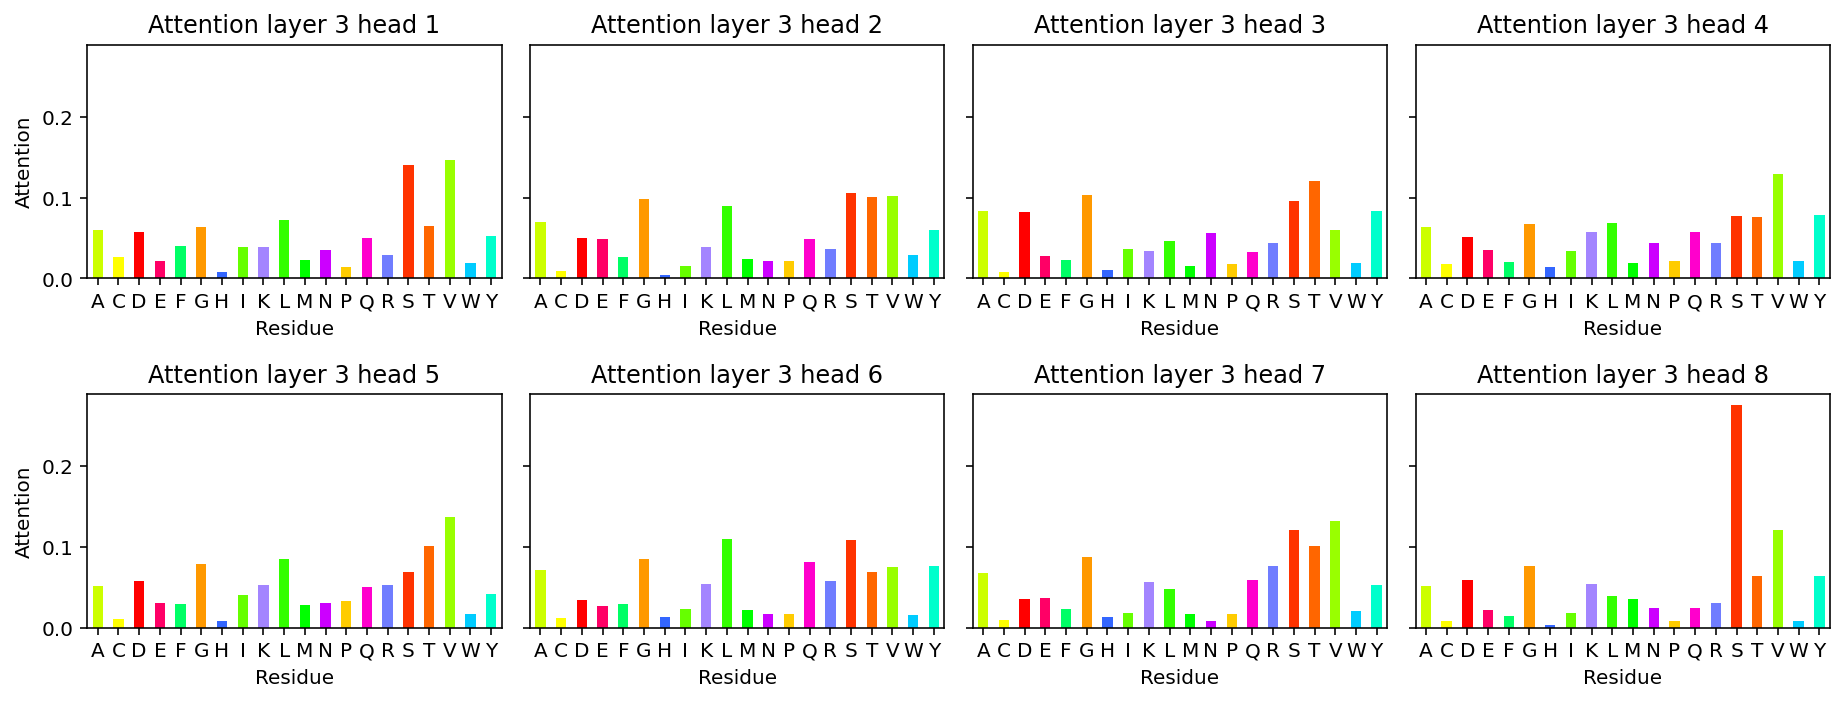

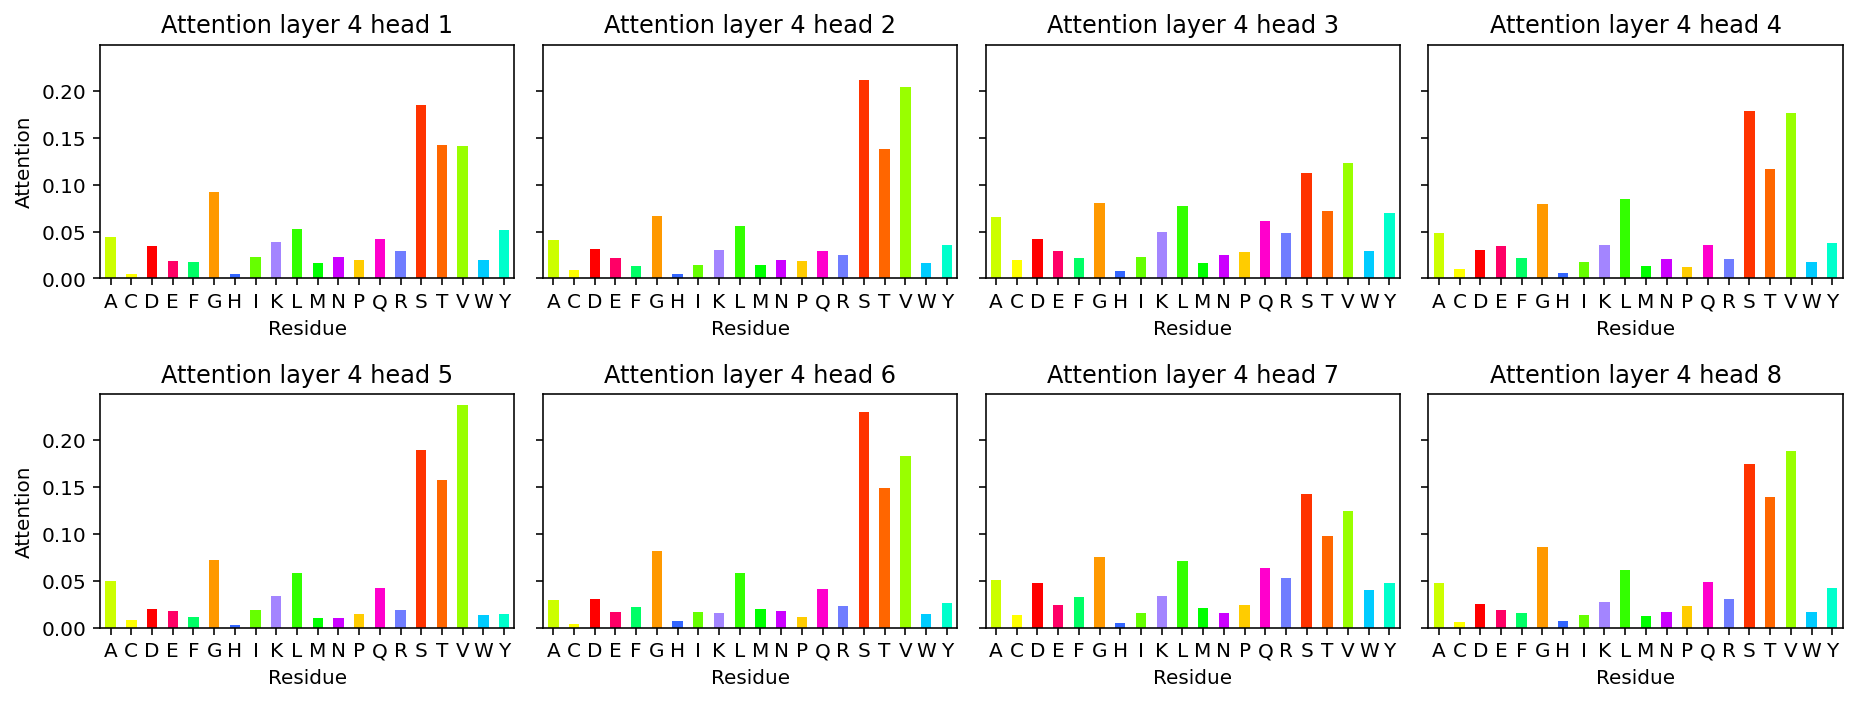

In [75]:
for layer, attn_layer in enumerate(mean_attentions_per_residue):
    fig, axes = plt.subplots(2, 4, figsize=(13, 5), sharey=True)
    for i, attn in enumerate(attn_layer):
        ax = pd.Series(attn, RESIDUES).plot.bar(ax=axes.flatten()[i], color=TAYLOR)
        ax.set_xticklabels(RESIDUES, rotation=0)
        ax.set_title(f'Attention layer {layer+1} head {i+1}')
        if i % 4 == 0:
            ax.set_ylabel(f'Attention')
        ax.set_xlabel('Residue')
    fig.tight_layout();
    plt.show()